In [1]:
# Constrained water and energy balance estimation 
# v4.2: adapted from v4.1 by treating SCF known, G estimated offline
# v4.3: adapted from v4.2 & 3.3 to handle to batch processing on OSC
# v4.4: adapted from v4.3 to update ipopt deprecation
# v4.5: moving σWRFG based on SCF 7/2/20 JLD
# v4.6: adding SDC to objective function: MD & JD: 9/28/20
# v4.7: adding "pseudo-valid prior" to starting points. remove SDC. MD: 1/7/21
# v4.8: tweak error parameters. MD & JD: 1/8/21
# v4.9 prior valid added to objective function. daily G capped in constraints. more outputs written 10/5/21
# v4.9.1 remove SWE from objective
# v4.9.2 added air temp
# v51 Converted to function but still uses textfile as input
# v52 Prototyping to pass the array directly to function [and fixed tab to 4 spaces]
# v53 To set tab to 4 spaces (by copying/pasting)
# v54 combine 9 separate textfile output in one txt file (due to file count limitation on Discover)
# v55 Fixing error due to missing days of data due to Polar nights
# v58 New updates by jack (Nov 2023)
# Jan 29, 2024: Due to error on obj function σWRFG becoming zero, fixed the minimum σWRFG to 25 
# Jun 21, 2024: No change for 1km run here. MODIS with UINT8 did not work likely because of missing due to no-data background and polar nights.

using Random
using JuMP
using Ipopt
using DelimitedFiles
# 0. read in data 

DataDir = "/Users/jldechow/Documents/GitHub/verse/Testing/BCK_Pix";
exp_dir = "/Users/jldechow/Documents/GitHub/verse/Testing/BCK_Pix";

WRFSWE=readdlm(DataDir * "/WRFSWE.txt"); #[m]
#WRFSWE = readdlm(DataDir * "/Dana16_mm.txt"); #[mm]
WRFP=readdlm(DataDir * "/WRFP.txt"); #[m]
WRFG=readdlm(DataDir * "/WRFG.txt");
MSCF=readdlm(DataDir * "/SCF2.txt");
AirT=readdlm(DataDir * "/AirT.txt");
AirT=(AirT./100).-273.15;
WRFP = WRFP./1000;
WRFSWE  = WRFSWE./1000;

lookIdx = 0;


In [2]:
# # 1. define parameters
# # 1.1 experiment parameters
# exp_dir = DataDir 

    σWSWE=0.4 # m
    RelPUnc=0.5 #[-]
    σWRFG=100 # W m^-2
    σWMPmin= .0001 #.001 #minimum uncertainty in fluxes: 1 mm/day
    badG = 500

    σSCF=.1 # combined uncertainty in observed SCF and SDC
    nt = length(WRFSWE)  # 366  #365  # TODO this need to be updated based on lenght of input vector rather than fixed 365 days
    t=1:nt
    SWEmin=1.0e-6 #1/1000 mm
    ρnew=100 #density of new snow
    Δt=86400 #daily
    Gmax=750 # to prevent craziness. more than adequate for daily
    Gmin=-300 # to prevent craziness. more than adequate for daily
    ρnew=100 #density of new snow
    z0=0.01 # roughness length used in SDC
    mf=1.0 # melt factor used in SDC
    ρWRF=350 #note: previous versions used time-varying snow density but that is not currently exported
    

# 1.2 physical parameters
    ρw=1000 #density of water
    Lf=0.334E6 #Latent heat of fusion J/kg
    cs_ice=2102 #specific heat capacity for ice J/kg/K

2102

In [3]:
# 1.3.0 Define several functions

function findSnowOffDate(data) # Determines the snow off date of input data
    startIdx = 365; i = 364
    while i > 105
        scfN = data[i]; scfNm1 = data[i+1];
        deltaSCF = scfN + scfNm1

        if i == 364
            if scfNm1 > 0
                snowOffDate = 365
                return snowOffDate
            end
        end

        if  deltaSCF > 0
            snowOffDate = i
            return snowOffDate
        end
    i = i-1
    end
end

function detSnowOffset(pred, meas)
    # find snow off date for meas and pred datasets
    snodPred = findSnowOffDate(pred)
    snodMeas = findSnowOffDate(meas)

    # edge cases
    if snodPred == snodMeas
        offset = 0; return offset;
    elseif snodPred == 365 
        offset = 60; return offset;
    end

    offset = snodPred - snodMeas;
    return offset
end

function scaleSWE(inSWE, offset,scaleF,nd)
    # take a SWE time series, the offset between snow off date from satellite/model, and scale factor to rescale SWE
    outSWE = zeros(nd,1)
    scaleP = (offset*scaleF)/100
    for i = 1 : nd
        outSWE[i] = inSWE[i] +scaleP*inSWE[i]
    end
    return outSWE
end

function offsetArray(inArr,offset,nd)
    outArr = inArr
    for i = 1:nd-offset
        outArr[i] = inArr[i+offset]
    end
    return outArr
end
        
    

offsetArray (generic function with 1 method)

In [4]:
offset = detSnowOffset(WRFSWE,MSCF)

60

In [5]:
#outSWE = offsetArray(WRFSWE,offset,nt);
#outP = offsetArray(WRFP,offset,nt);
#WRFSWE = outSWE; WRFP = outP;

In [6]:
# 1.3.0 Find offset in timing for WRF peak SWE vs MSCF off date

maxWRF = argmax(WRFSWE) ; noSnowSCF = 0 ; noSnowWRF = 0 ; 
for i = 150:nt
    if MSCF[i] == 0
        noSnowSCF = i
        break
    end
end

for i = 150:nt
    if WRFSWE[i] == 0
        noSnowWRF = i
        break
    end
end


offsetIdx = noSnowWRF - maxWRF[1];

#if abs(noSnowSCF-noSnowWRF)<5
#    offsetIdx = 0
#else
#    offsetIdx = wrfOffset
#end

if noSnowWRF == 0
    offsetIdx = 65;
end

predMaxSWE = noSnowSCF - offsetIdx

200

In [7]:
# 1.3 Fill in missing SCF [Feb 23, 2023]
    MissingSCFData=zeros(nt,1)
    for i=1:nt
        if ismissing(MSCF[i])
            MissingSCFData[i]=1
            MSCF[i]=1  # June 20, 2024: cannot convert a value to missing for assignment. When using uint8 based data.
        end
    end

    # New Updates from Jack (Nov, 2023)
    σWRFG = zeros(nt,1) .+ 25  # maybe 15 is not being used, but we still need to initialze the array
    σWRFG_rel = 0.5
    for i=1:nt
        if MissingSCFData[i]==1 # missing data check
	        σWRFG[i] = badG
        elseif MSCF[i]>=0.1 && WRFSWE[i]>=0.1  # if both are snow covered
            σWRFG[i] = abs(WRFG[i]) * σWRFG_rel  # when WRFG == zero, σWRFG also becomes zero which creates problem of objective function
            # Jan 29, 2024 To solve this problem in obj function: Expression contains an invalid NaN constant. This could be produced by `Inf - Inf`.
            if σWRFG[i] < 25  # or == 0 because this is what was actually causing problem.  
                σWRFG[i] = 25  # σWRFG_rel  #abs(WRFG[i] + eps(Float32)) * σWRFG_rel
            end
        elseif MSCF[i]<0.1 && WRFSWE[i]<0.1 # if both not snowy
            σWRFG[i] = 25
        else
            σWRFG[i] = 500 #if they disagree, then don’t use prior in cost function
        end
    end
 # 1.4 Match up SWE and MSCF
    for i=1:nt
        if MSCF[i]==0  # Nov 04, 2022: "ERROR: LoadError: TypeError: non-boolean (Missing) used in boolean context" because some days there was no MODIS data
            WRFSWE[i] = 0
        end
    end

    for i = 100:nt
        if WRFSWE[i] == 0
            lookIdx = i;
            break
        end
    end
   

In [8]:
# 2. compute useful variables and set up  arrays
    # 2.1 define SWEmax: upper limit of SWE, based on observed SCF
    SWEmax=zeros(nt,1)
    for i=1:nt
        if MSCF[i]==0  # TypeError: non-boolean (Missing) used in boolean context
            SWEmax[i]=SWEmin
        else
            SWEmax[i]=5.0
        end
    end

In [9]:
# 2.2 SDC denominator: dependent only on snow density
    DenomSDC=2.5.*z0.*(ρWRF./ρnew).^mf
    
# 2.3 Uncertainty for accumulation 
    σWRFP=zeros(nt,1) 
    for i=1:nt
        if WRFP[i]==0.
            σWRFP[i]=σWMPmin
        else
            σWRFP[i]=WRFP[i]*RelPUnc
        end
    end
    # Jan 30, 2023: Modify σWRFP based on number snowy days  
    nsnowday = 0  # number of snow days
    for i=1:nt
        if WRFP[i]>0.001 && AirT[i] < 1.5
            # there is precipitation and temperature is likely to convert it to snow.
            nsnowday += 1
        end
    end
    if nsnowday > 0
        # to prevent σWRFP from becoming zero if nsnowday=0.
        σWRFP = σWRFP .* sqrt(nsnowday * 0.5)
    end

365×1 Matrix{Float64}:
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 ⋮
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0036571847095819483
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897
 0.0007314369419163897

In [10]:
# 3. Solve
    # 3.1 Solve for G    
    Gmelt_pv=zeros(nt,1)
    G_pv=zeros(nt,1)
    U_pv=zeros(nt,1)
    SWEpv=WRFSWE
    for i=2:nt
        Gmelt_pv[i-1]=-(SWEpv[i]-SWEpv[i-1]-WRFP[i-1])*Lf*ρw/Δt
        if Gmelt_pv[i-1]<0.
            Gmelt_pv[i-1]=0
            SWEpv[i]=SWEpv[i-1]+WRFP[i-1]
        end
    end
    for i=2:nt
        if Gmelt_pv[i]>0. && MSCF[i] >0.  # TypeError: non-boolean (Missing) used in boolean context
            G_pv[i]=Gmelt_pv[i]/MSCF[i]
            U_pv[i]=0.
        else
            G_pv[i]=WRFG[i]
            U_pv[i]=U_pv[i-1]+WRFP[i-1]*AirT[i-1]*ρw*cs_ice + G_pv[i-1]*MSCF[i-1]*Δt  # MethodError: Cannot `convert` an object of type Missing to an object of type Float64
            if U_pv[i]>0. || SWEpv[i]==0.
                U_pv[i]=0.
            end
        end
    end

    for i=2:nt
        if Gmelt_pv[i] > Gmax
            σWRFG[i]= 500
            Gmelt_pv[i] = Gmax
        end
    end

In [11]:
# 3.2 Solve for the posterior using prior valid
    m = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_iter"=>5000))
    set_silent(m)
    @variable(m, SWEmin <= SWE[i=1:nt] <= SWEmax[i],start=SWEpv[i] )
    @variable(m,  Precip[i=1:nt]>=0. ,start=WRFP[i])
    @variable(m,  G[i=1:nt] , start=G_pv[i])
    @variable(m, 0 <= Gmelt[i=1:nt] <= Gmax, start=Gmelt_pv[i])
    @variable(m, Us[i=1:nt] <=0, start=U_pv[i])
    @objective(m,Min,sum((Precip-WRFP).^2 ./σWRFP.^2)+ sum((Gmelt-Gmelt_pv).^2 ./σWRFG.^2) )
    for i in 1:nt-1
        @constraint(m,SWE[i+1]==SWE[i]+Precip[i]-Gmelt[i]*Δt/Lf/ρw)
        @NLconstraint(m,Us[i+1]==Us[i]+(1-(tanh(Us[i]/10000)+1))*G[i]*MSCF[i]*Δt+
                                Precip[i]*AirT[i]*ρw*cs_ice) #m x K x kg/m3 x J/kg/K
    end
    @constraint(m,Us[1]==0) 
    @constraint(m,Us[nt]==0)
    for i in 1:nt
        @NLconstraint(m,Gmelt[i]==G[i]*MSCF[i]*(tanh(Us[i]/10000)+1))
    end
    #for i in 1:predMaxSWE-1    
    #    @constraint(m,SWE[i] <= SWE[predMaxSWE])
    #end
    #for i in predMaxSWE+1:nt    
    #    @constraint(m,SWE[i] <= SWE[predMaxSWE])
    #end
        
    #@constraint(m,sum(SWE[1:nt])>=sum(SWEpv[1:nt])-0.2*sum(SWEpv[1:nt]))
optimize!(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [12]:
# 4. output
    SWEhat=JuMP.value.(SWE);
    GmeltHat=JuMP.value.(Gmelt);
    Ghat=JuMP.value.(G);
    Ushat=JuMP.value.(Us);
    Phat=JuMP.value.(Precip);

In [13]:
# 5. Write Files
    writedlm(exp_dir * "/SWE.txt",SWEhat)
    writedlm(exp_dir * "/Gmelt.txt",GmeltHat)
    writedlm(exp_dir * "/G.txt",Ghat)
    writedlm(exp_dir * "/Precip.txt",Phat)
    writedlm(exp_dir * "/Us.txt",Ushat)
    writedlm(exp_dir * "/Gpv.txt",G_pv)
    writedlm(exp_dir * "/Gmeltpv.txt",Gmelt_pv)
    writedlm(exp_dir * "/Upv.txt",U_pv)
    writedlm(exp_dir * "/SWEpv.txt",SWEpv)

In [29]:
# Test resample SWE with 1% scale factor per day
# Clear and reload WRFSWE to make sure snow off date is correctly calculated
WRFSWE = zeros(nt,1)
WRFSWE = readdlm(DataDir * "/WRFSWE.txt"); #[m]
offset = detSnowOffset(WRFSWE,MSCF);
scaledSWE = scaleSWE(SWEhat,offset,3,nt);

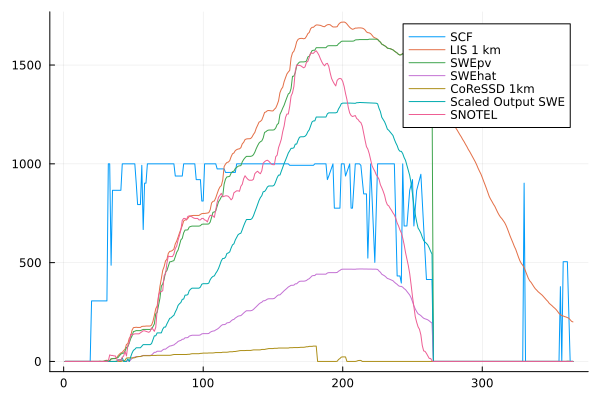

In [30]:
using Plots
# reload WRFSWE to make sure it isn't the changed version
SNOTEL = readdlm(DataDir * "/BCK_mm.txt"); #[mm]
csd = readdlm(DataDir *"/CSD_SWE.txt"); 
WRFSWE=readdlm(DataDir * "/WRFSWE.txt"); #[m]
sweHatPlot = SWEhat.*1000;
mSCFPlot = MSCF.*1000;
plot(t,mSCFPlot,label="SCF")
plot!(t,WRFSWE,label="LIS 1 km")
plot!(t,SWEpv.*1000,label = "SWEpv")
plot!(t,sweHatPlot,label="SWEhat")
plot!(t,csd.*1000,label = "CoReSSD 1km")
plot!(t,scaledSWE.*1000, label = "Scaled Output SWE")
plot!(t,SNOTEL,label = "SNOTEL")

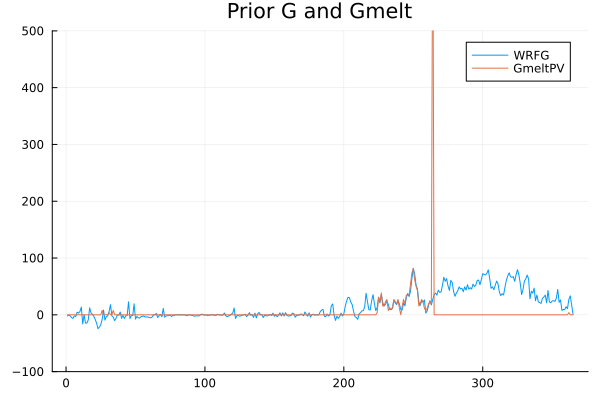

In [16]:
plot(t,WRFG,label="WRFG")
plot!(t,Gmelt_pv,label="GmeltPV")
plot!(ylimits=(-100,500))
plot!(title = "Prior G and Gmelt")

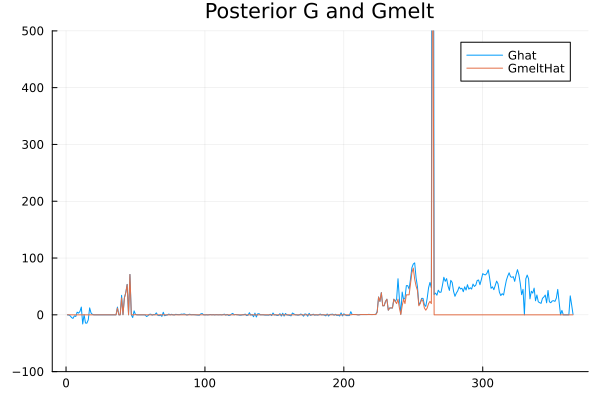

In [17]:
plot(t,Ghat,label="Ghat")
plot!(t,GmeltHat,label="GmeltHat")
plot!(ylimits=(-100,500))
plot!(title = "Posterior G and Gmelt")

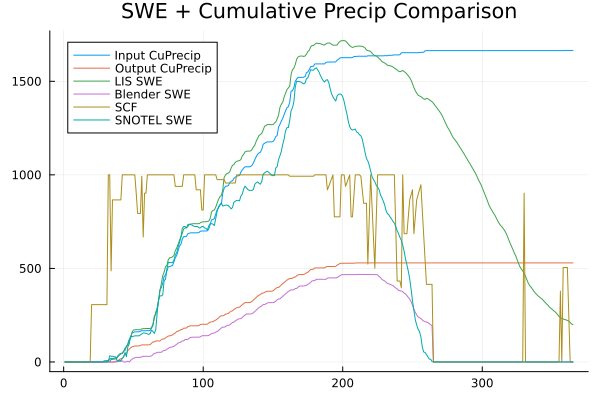

In [18]:
holdWRFP = WRFP.*1000
holdPhat = Phat.*1000;
cumuWRFP = cumsum(holdWRFP[:])
cumuPhat = cumsum(holdPhat[:])

plot(t,cumuWRFP,label = "Input CuPrecip")
plot!(t,cumuPhat,label = "Output CuPrecip")
plot!(t,WRFSWE,label="LIS SWE")
plot!(t,sweHatPlot,label="Blender SWE")
plot!(t,mSCFPlot,label="SCF")
plot!(title = "SWE + Cumulative Precip Comparison")
plot!(t,SNOTEL,label = "SNOTEL SWE")

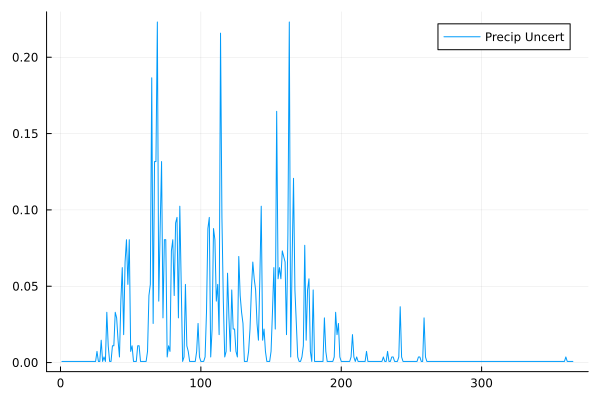

In [19]:
plot(t,σWRFP,label = "Precip Uncert")
#plot!(t,σWRFG,label = "Heat Flux Uncert")


In [20]:
look = argmax(WRFSWE)
scfOffDate = 0
wrfNoSnowDate = 0
for i = 150:nt
    if MSCF[i] == 0
        scfOffDate = i
        break
    end
end

for i = 150:nt
    if WRFSWE[i] == 0
        wrfNoSnowDate = i
        break
    end
end

In [21]:
findmax(WRFSWE)[1]

1718.0

In [22]:
findmax(WRFSWE)[1]-(findmax(csd)[1]*1000)

1640.3952367901802

In [23]:
findmax(WRFSWE)[1]-findmax(sweHatPlot)[1]

1249.8929801101644

In [24]:
scfOffDate

265

In [25]:
wrfNoSnowDate

0

In [26]:
wrfTimingOffset = wrfNoSnowDate - look[1]

-201

In [27]:
findmax(WRFP)[1]

0.061

In [28]:
#for i in 1:predMaxSWE-3
#        @NLconstraint(m,SWE[i]<findmax(SWE)[1])
#    end
#    for i in predMaxSWE+3:nt
#        @NLconstraint(m,SWE[i]<findmax(SWE)[1])
#    end 